In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import math
from math import cos, sin, tanh
from helper import get_trial_list

## Getting started (this part can be ignored)

                  timestamp         x         z
0   1900-01-01 11:04:30.620  1.484322  0.716557
1   1900-01-01 11:04:30.730  1.484851  0.716145
2   1900-01-01 11:04:30.840  1.485970  0.715341
3   1900-01-01 11:04:30.950  1.487544  0.714390
4   1900-01-01 11:04:31.010  1.488478  0.713396
..                      ...       ...       ...
152 1900-01-01 11:04:45.830 -3.181267  5.296037
153 1900-01-01 11:04:45.930 -3.194767  5.276099
154 1900-01-01 11:04:46.040 -3.203582  5.264789
155 1900-01-01 11:04:46.110 -3.205243  5.264628
156 1900-01-01 11:04:46.220 -3.219514  5.252650

[157 rows x 3 columns]
                  timestamp         x         z
0   1900-01-01 11:04:30.620 -2.959004  5.222799
1   1900-01-01 11:04:30.730 -2.955826  5.219689
2   1900-01-01 11:04:30.840 -2.943017  5.204636
3   1900-01-01 11:04:30.950 -2.920465  5.179360
4   1900-01-01 11:04:31.010 -2.904829  5.158830
..                      ...       ...       ...
152 1900-01-01 11:04:45.830  1.348743  0.950259
153 1900-01-01 1

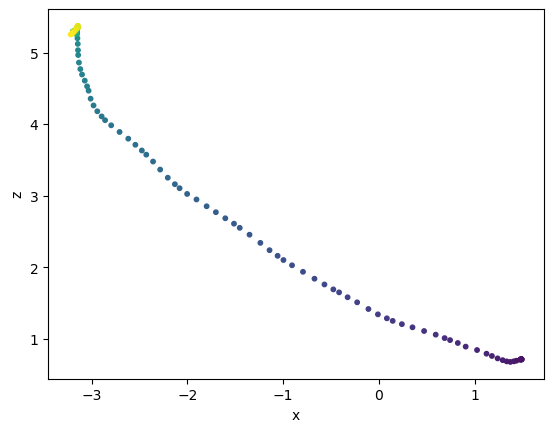

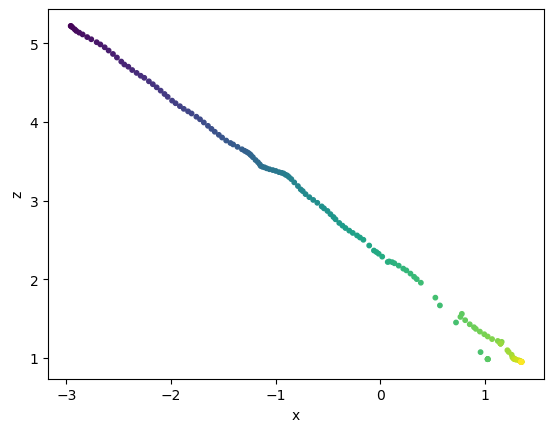

In [2]:
# Drawing a single trajectory 
# --- Insert ---
pp_id = '02'
trial = '10'
# --------------

path_Human = './newdata/id_' + pp_id + '/Human'
path_Spot = './newdata/id_' + pp_id + '/Spot'

df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ trial + ".txt", sep=" ", header=None, 
                 names=["timestamp", "x", "z"])
df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ trial + ".txt", sep=" ", header=None, 
                 names=["timestamp", "x", "z"])

df_Human['timestamp'] = pd.to_datetime(df_Human['timestamp'], format = '%H:%M:%S:%f')
df_Spot['timestamp'] = pd.to_datetime(df_Spot['timestamp'], format = '%H:%M:%S:%f')

# display DataFrame
print(df_Human)
print(df_Spot)

df_Human.plot.scatter(x = 'x', y = 'z', c = 'timestamp', s = 10);
df_Spot.plot.scatter(x = 'x', y = 'z', c = 'timestamp', s = 10);

In [3]:
## Separate dominant and submissive, then put it in a dataframe

#--- Insert here ---
pp_id = '01'
position_of = 'Spot'
scenario = 'fronting' # fronting or crossing
apparance = 'dom' # 'dom' or 'sub' 
#-------------------

trial_list = get_trial_list(scenario, apparance)
df_list = []

# load data files, put it in a list
for i in range(8): # change later to the length of the list
    filepath = './newdata/id_' + pp_id + '/' + position_of + '/' + pp_id + '_' + str(trial_list[int(pp_id)][i]) + '.txt'
    df = pd.read_csv(filepath, sep=" ", header=None, names=["timestamp", "x", "z"])
    df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%H:%M:%S:%f')
    df_list.append(df)

# Concatenate the df in the list horizontally
df = pd.concat(df_list, axis=1, ignore_index=False)

df
# Draw four lines in one plot 
#(Probably need to normalize the time to draw multiple trajectories in one plot)

,timestamp,x,z,timestamp,x,z,timestamp,x,z,timestamp,...,z,timestamp,x,z,timestamp,x,z,timestamp,x,z
0,1900-01-01 03:08:06.400,2.302944,5.933489,1900-01-01 03:08:27.620,-1.236823,1.169237,1900-01-01 03:10:56.420,-1.119105,1.312351,1900-01-01 03:11:45.000,...,5.964508,1900-01-01 03:12:31.320,-1.150076,1.314698,1900-01-01 03:12:53.220,2.410275,5.959477,1900-01-01 03:13:36.800,2.502175,6.042627
1,1900-01-01 03:08:06.520,2.293928,5.909678,1900-01-01 03:08:27.720,-1.234572,1.169780,1900-01-01 03:10:56.500,-1.118937,1.312778,1900-01-01 03:11:45.100,...,5.964537,1900-01-01 03:12:31.420,-1.149325,1.317957,1900-01-01 03:12:53.300,2.410240,5.959622,1900-01-01 03:13:36.900,2.502064,6.042599
2,1900-01-01 03:08:06.610,2.284491,5.870634,1900-01-01 03:08:27.830,-1.232159,1.182333,1900-01-01 03:10:56.600,-1.115981,1.325414,1900-01-01 03:11:45.200,...,5.963884,1900-01-01 03:12:31.530,-1.144150,1.336301,1900-01-01 03:12:53.400,2.411297,5.961002,1900-01-01 03:13:37.020,2.499049,6.037822
3,1900-01-01 03:08:06.720,2.271422,5.838198,1900-01-01 03:08:27.900,-1.228101,1.199047,1900-01-01 03:10:56.700,-1.101699,1.348948,1900-01-01 03:11:45.310,...,5.966101,1900-01-01 03:12:31.630,-1.127569,1.362504,1900-01-01 03:12:53.510,2.414044,5.965832,1900-01-01 03:13:37.120,2.492511,6.017727
4,1900-01-01 03:08:06.830,2.256602,5.809275,1900-01-01 03:08:28.010,-1.209619,1.230172,1900-01-01 03:10:56.810,-1.082846,1.385844,1900-01-01 03:11:45.420,...,5.969727,1900-01-01 03:12:31.710,-1.111503,1.389935,1900-01-01 03:12:53.610,2.415642,5.969256,1900-01-01 03:13:37.220,2.480292,5.984984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,NaT,NaN,NaN,NaT,NaN,NaN,1900-01-01 03:11:20.500,2.468749,6.060694,NaT,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
242,NaT,NaN,NaN,NaT,NaN,NaN,1900-01-01 03:11:20.610,2.467185,6.062006,NaT,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
243,NaT,NaN,NaN,NaT,NaN,NaN,1900-01-01 03:11:20.720,2.466573,6.062155,NaT,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN
244,NaT,NaN,NaN,NaT,NaN,NaN,1900-01-01 03:11:20.820,2.466681,6.062024,NaT,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN


## Distance between Spot and Human

In [4]:
# Calculate distance between the objects over time (fronting scenario)

def get_df_distance(pp_ids, apparance):
    
    df_plot= None

    for pp_id in pp_ids:
        path_Human = './newdata/id_' + pp_id + '/Human'
        path_Spot = './newdata/id_' + pp_id + '/Spot'

        trials = get_trial_list('fronting', apparance)

        for i in trials[int(pp_id)-1]:
            df_Human = pd.read_csv(path_Human + "/" + pp_id + "_"+ str(i) + ".txt", sep=" ", header=None, 
                             names=["ts", "x_human", "z_human"])
            df_Spot = pd.read_csv(path_Spot +  "/" + pp_id + "_"+ str(i) + ".txt", sep=" ", header=None, 
                             names=["ts", "x_spot", "z_spot"])

            # Check if the length of the dataframe matchs
            if not df_Human.size == df_Spot.size: 
                print("Warning: Time stamp does not match!!!")
                break 

            # Concatenate to one dataframe for plotting
            df = pd.concat([df_Human, df_Spot], axis=1)
            df['time'] = np.arange(df.shape[0])/10
            print("--- ", i )

            # Calculate distance between two objects and append to list
            df['distance'] = np.sqrt((df['x_human']-df['x_spot'])**2 + (df['z_human']-df['z_spot'])**2)
            
            # Add some columns that can be useful later 
            df['trial'] = i
            df['pp_id'] = int(pp_id)

            df_plot = pd.concat([df_plot, df.loc[:200, 'time':]], axis = 0)
            print(df_plot)
            
            sns.lineplot(df.loc[:200, 'distance'], legend= "full")
            
    return df_plot

---  1
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
196  19.6  6.353848      1      1
197  19.7  6.353073      1      1
198  19.8  6.352846      1      1
199  19.9  6.352784      1      1
200  20.0  6.354304      1      1

[201 rows x 4 columns]
---  4
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
104  10.4  4.473065      4      1
105  10.5  4.524822      4      1
106  10.6  4.555050      4      1
107  10.7  4.603595      4      1
108  10.8  4.668761      4      1

[310 rows x 4 columns]
---  6
    time  distance  trial  pp_id
0    0.0  6.128754      1      1
1    0.1  6.132862      1      1
2    0.2  6.1376

---  1
    time  distance  trial  pp_id
0    0.0  6.128754      1      1
1    0.1  6.132862      1      1
2    0.2  6.137634      1      1
3    0.3  6.140104      1      1
4    0.4  6.142322      1      1
..   ...       ...    ...    ...
91   9.1  3.992539      1      4
92   9.2  4.052067      1      4
93   9.3  4.097920      1      4
94   9.4  4.144871      1      4
95   9.5  4.193576      1      4

[3899 rows x 4 columns]
---  1
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
121  12.1  5.308807      1      5
122  12.2  5.355408      1      5
123  12.3  5.386670      1      5
124  12.4  5.448749      1      5
125  12.5  5.510714      1      5

[4025 rows x 4 columns]
---  3
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634    

---  14
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
196  19.6  3.689237     14      7
197  19.7  3.735019     14      7
198  19.8  3.762537     14      7
199  19.9  3.776927     14      7
200  20.0  3.818464     14      7

[8504 rows x 4 columns]
---  1
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
192  19.2  6.084852      1      8
193  19.3  6.086394      1      8
194  19.4  6.087996      1      8
195  19.5  6.089333      1      8
196  19.6  6.090273      1      8

[8701 rows x 4 columns]
---  2
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2 

---  15
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
184  18.4  6.068238     15     10
185  18.5  6.072295     15     10
186  18.6  6.074668     15     10
187  18.7  6.075442     15     10
188  18.8  6.075216     15     10

[12782 rows x 4 columns]
---  18
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
155  15.5  6.353555     18     11
156  15.6  6.350305     18     11
157  15.7  6.338977     18     11
158  15.8  6.334206     18     11
159  15.9  6.329479     18     11

[12942 rows x 4 columns]
---  19
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     

---  31
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
196  19.6  2.740954     31     13
197  19.7  2.765923     31     13
198  19.8  2.807539     31     13
199  19.9  2.832913     31     13
200  20.0  2.866272     31     13

[16791 rows x 4 columns]
---  17
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
153  15.3  6.279633     17     14
154  15.4  6.268278     17     14
155  15.5  6.267604     17     14
156  15.6  6.211840     17     14
157  15.7  6.186869     17     14

[16949 rows x 4 columns]
---  18
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     

---  32
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
159  15.9  5.845496     32     16
160  16.0  5.850495     32     16
161  16.1  5.851912     32     16
162  16.2  5.862839     32     16
163  16.3  5.867122     32     16

[20731 rows x 4 columns]
---  20
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
150  15.0  6.185283     20     17
151  15.1  6.193003     20     17
152  15.2  6.192271     20     17
153  15.3  6.201375     20     17
154  15.4  6.208427     20     17

[20886 rows x 4 columns]
---  21
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     

---  31
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
146  14.6  6.571324     31     19
147  14.7  6.569471     31     19
148  14.8  6.569326     31     19
149  14.9  6.567989     31     19
150  15.0  6.567040     31     19

[24736 rows x 4 columns]
---  17
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     0.2  6.137634      1      1
3     0.3  6.140104      1      1
4     0.4  6.142322      1      1
..    ...       ...    ...    ...
194  19.4  6.438569     17     20
195  19.5  6.390320     17     20
196  19.6  6.312929     17     20
197  19.7  6.293436     17     20
198  19.8  5.935331     17     20

[24935 rows x 4 columns]
---  19
     time  distance  trial  pp_id
0     0.0  6.128754      1      1
1     0.1  6.132862      1      1
2     

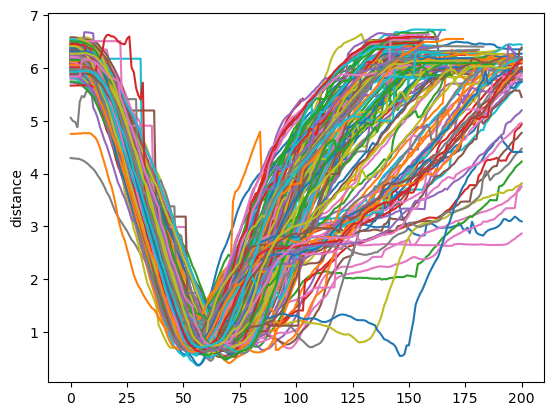

In [5]:
df_dis_dom = get_df_distance(pp_ids= ["%02d" % x for x in range(1, 22)], apparance = 'dom')

---  2
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
123  12.3  6.189610      2      1
124  12.4  6.205456      2      1
125  12.5  6.230088      2      1
126  12.6  6.253175      2      1
127  12.7  6.282381      2      1

[128 rows x 4 columns]
---  3
    time  distance  trial  pp_id
0    0.0  6.344672      2      1
1    0.1  6.320642      2      1
2    0.2  6.283391      2      1
3    0.3  6.248953      2      1
4    0.4  6.213757      2      1
..   ...       ...    ...    ...
77   7.7  3.170520      3      1
78   7.8  3.335722      3      1
79   7.9  3.469567      3      1
80   8.0  3.597909      3      1
81   8.1  3.720759      3      1

[210 rows x 4 columns]
---  5
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      

---  7
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
123  12.3  5.131851      7      3
124  12.4  5.189338      7      3
125  12.5  5.226215      7      3
126  12.6  5.260119      7      3
127  12.7  5.329525      7      3

[2834 rows x 4 columns]
---  8
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
99    9.9  4.464102      8      3
100  10.0  4.568597      8      3
101  10.1  4.680514      8      3
102  10.2  4.748039      8      3
103  10.3  4.836159      8      3

[2938 rows x 4 columns]
---  12
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2 

---  9
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
157  15.7  6.237973      9      6
158  15.8  6.262060      9      6
159  15.9  6.273428      9      6
160  16.0  6.275781      9      6
161  16.1  6.273568      9      6

[6774 rows x 4 columns]
---  10
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
157  15.7  6.012217     10      6
158  15.8  6.013908     10      6
159  15.9  6.015533     10      6
160  16.0  6.017039     10      6
161  16.1  6.018189     10      6

[6936 rows x 4 columns]
---  11
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2

     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
140  14.0  6.389106      8      9
141  14.1  6.417452      8      9
142  14.2  6.397165      8      9
143  14.3  6.394963      8      9
144  14.4  6.429300      8      9

[11097 rows x 4 columns]
---  9
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
154  15.4  6.185320      9      9
155  15.5  6.180084      9      9
156  15.6  6.177112      9      9
157  15.7  6.176910      9      9
158  15.8  6.175348      9      9

[11256 rows x 4 columns]
---  10
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.28

---  30
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
151  15.1  5.842942     30     11
152  15.2  5.843181     30     11
153  15.3  5.843697     30     11
154  15.4  5.843408     30     11
155  15.5  5.843442     30     11

[14345 rows x 4 columns]
---  31
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
162  16.2  6.508978     31     11
163  16.3  6.524885     31     11
164  16.4  6.537755     31     11
165  16.5  6.538442     31     11
166  16.6  6.535121     31     11

[14512 rows x 4 columns]
---  19
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     

     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
164  16.4  6.349989     21     14
165  16.5  6.354416     21     14
166  16.6  6.353853     21     14
167  16.7  6.352587     21     14
168  16.8  6.352276     21     14

[17578 rows x 4 columns]
---  24
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
146  14.6  6.085395     24     14
147  14.7  6.085512     24     14
148  14.8  6.084701     24     14
149  14.9  6.084378     24     14
150  15.0  6.084085     24     14

[17729 rows x 4 columns]
---  25
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.2

---  17
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
196  19.6  6.692675     17     17
197  19.7  6.693882     17     17
198  19.8  6.694276     17     17
199  19.9  6.694816     17     17
200  20.0  6.695395     17     17

[21570 rows x 4 columns]
---  18
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
196  19.6  3.211930     18     17
197  19.7  3.229706     18     17
198  19.8  3.246013     18     17
199  19.9  3.272028     18     17
200  20.0  3.296939     18     17

[21771 rows x 4 columns]
---  19
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     

---  32
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
154  15.4  6.424668     32     19
155  15.5  6.426322     32     19
156  15.6  6.427210     32     19
157  15.7  6.427843     32     19
158  15.8  6.427865     32     19

[25639 rows x 4 columns]
---  18
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     0.2  6.283391      2      1
3     0.3  6.248953      2      1
4     0.4  6.213757      2      1
..    ...       ...    ...    ...
178  17.8  6.223474     18     20
179  17.9  6.220115     18     20
180  18.0  6.217827     18     20
181  18.1  6.215957     18     20
182  18.2  6.215228     18     20

[25822 rows x 4 columns]
---  20
     time  distance  trial  pp_id
0     0.0  6.344672      2      1
1     0.1  6.320642      2      1
2     

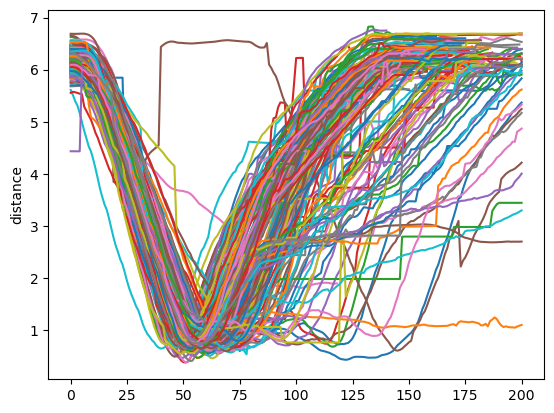

In [6]:
df_dis_sub = get_df_distance(pp_ids= ["%02d" % x for x in range(1, 22)], apparance = 'sub')

<Axes: xlabel='time', ylabel='distance'>

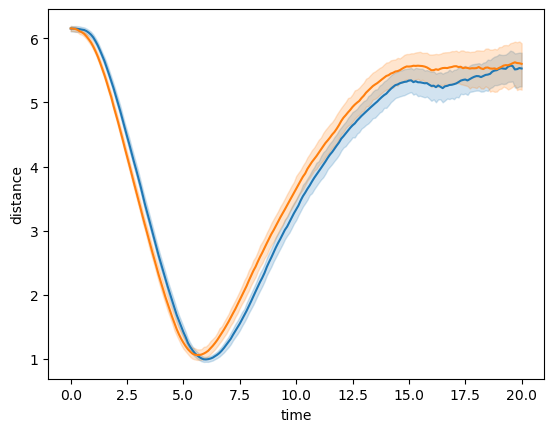

In [7]:
sns.lineplot(data = df_dis_dom.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")
sns.lineplot(data = df_dis_sub.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")
# how to show which color is which????  
# Now blue is dominant, orange is submissive

<Axes: xlabel='time', ylabel='distance'>

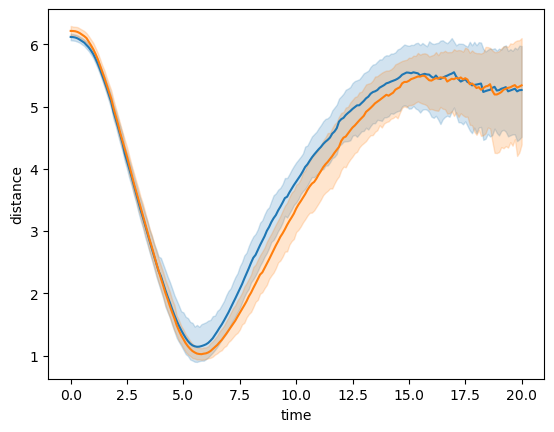

In [9]:
# See if there is difference over time 
# Compare first 3 and last 3 of all the participants 

### This is not correct, I am fogetting to consider pp who did crossing first!!!!!
def select_timing(df, timing, condition = 'fronting'):
    if timing == 'early' and scenario == 'fronting':
        df_new = df[df['trial']<=4]
        df_new2 = df[(df['trial']>16) & (df['trial']<=20)]

    if timing == 'late' and scenario == 'fronting':
        df_new = df[(df['trial']>12) & (df['trial']<=16)]
        df_new2 = df[df['trial']>28]
    
    df_timing = pd.concat([df_new, df_new2], axis=0)
        
    return df_timing
    
df_dis_dom_early = select_timing(df_dis_dom, 'early')
df_dis_sub_early = select_timing(df_dis_sub, 'early')
df_dis_dom_late = select_timing(df_dis_dom, 'late')
df_dis_sub_late = select_timing(df_dis_sub, 'late')

# Plot for submissive
sns.lineplot(data = df_dis_sub_early.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")
sns.lineplot(data = df_dis_sub_late.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")

<Axes: xlabel='time', ylabel='distance'>

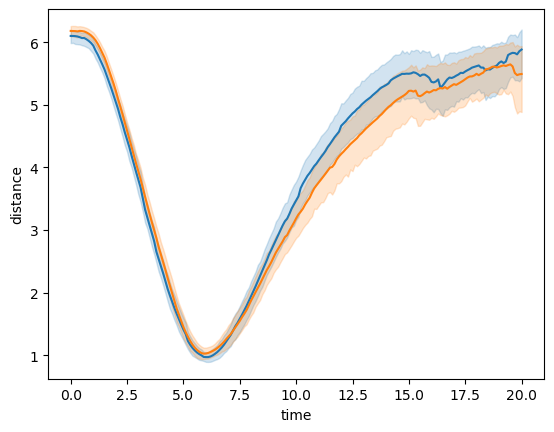

In [10]:
# Plot for dominant
sns.lineplot(data = df_dis_dom_early.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")
sns.lineplot(data = df_dis_dom_late.loc[:, ['time', 'distance']], x = 'time', y = 'distance', legend = "full")

## Trajectories
### Note: Coordinate of participants 11~13 is not aligned to the axis :( I am still figuring out why. 

In [11]:
def get_trajectory_df(pp_ids, apparance, position_of, scenario):
    
    df_plot= None
    
    #Iterate over participants
    for pp_id in pp_ids:
        path = './traj_data/id_' + pp_id + '/' + position_of
       # path_Spot = './traj_data/id_' + pp_id + '/Spot'

        trials = get_trial_list(scenario, apparance)
        
        # Add each trial to one dataframe
        for i in trials[int(pp_id)-1]:
            df = pd.read_csv(path + "/" + pp_id + "_"+ str(i) + ".csv")
            
            # Add some columns that can be useful later 
            df['trial'] = str(i)
            df['pp_id'] = pp_id
            print(df['z'])
            df['z'] = df['z'] - df.loc[0]['z'] # To adjust noise in the start 
            
            df_plot = pd.concat([df_plot, df.loc[:200]], axis = 0)
            
    return df_plot

0      0.172880
1      0.172572
2      0.171456
3      0.170784
4      0.170070
         ...   
202    0.291945
203    0.291203
204    0.291054
205    0.292272
206    0.352860
Name: z, Length: 207, dtype: float64
0     -0.226744
1     -0.226853
2     -0.227890
3     -0.228115
4     -0.227890
         ...   
104   -0.012080
105   -0.008572
106   -0.006121
107   -0.003165
108   -0.000067
Name: z, Length: 109, dtype: float64
0    -0.362463
1    -0.362490
2    -0.363595
3    -0.364478
4    -0.364294
        ...   
70    0.054207
71    0.061680
72    0.067136
73    0.073315
74    0.074186
Name: z, Length: 75, dtype: float64
0      0.181993
1      0.182107
2      0.181275
3      0.178309
4      0.174258
         ...   
99     0.390207
100    0.391614
101    0.391030
102    0.392148
103    0.389440
Name: z, Length: 104, dtype: float64
0      0.185612
1      0.184341
2      0.184699
3      0.182989
4      0.179415
         ...   
135    0.482226
136    0.482751
137    0.482981
138    0.481698


0      0.404759
1      0.404122
2      0.404266
3      0.404384
4      0.405084
         ...   
252   -0.101584
253   -0.105261
254   -0.109692
255   -0.113377
256   -0.119694
Name: z, Length: 257, dtype: float64
0      0.369050
1      0.368881
2      0.368885
3      0.368657
4      0.369171
         ...   
207   -0.153875
208   -0.155165
209   -0.156024
210   -0.156024
211   -0.156548
Name: z, Length: 212, dtype: float64
0      0.361765
1      0.361207
2      0.361434
3      0.362564
4      0.362506
         ...   
271   -0.172031
272   -0.171590
273   -0.171231
274   -0.170824
275   -0.170747
Name: z, Length: 276, dtype: float64
0      0.238872
1      0.238872
2      0.238872
3      0.238872
4      0.238872
         ...   
192   -0.097393
193   -0.102427
194   -0.106882
195   -0.109237
196   -0.111390
Name: z, Length: 197, dtype: float64
0      0.290647
1      0.290534
2      0.290425
3      0.288440
4      0.291185
         ...   
152   -0.102693
153   -0.105258
154   -0.104685
155 

0     -0.064581
1     -0.064479
2     -0.064075
3     -0.065423
4     -0.066736
         ...   
171   -1.712132
172   -1.713657
173   -1.713864
174   -1.712136
175   -1.708166
Name: z, Length: 176, dtype: float64
0      1.495144
1      1.494658
2      1.493233
3      1.491347
4      1.490029
         ...   
171   -0.138942
172   -0.141110
173   -0.141883
174   -0.142293
175   -0.142811
Name: z, Length: 176, dtype: float64
0      1.572719
1      1.571142
2      1.553515
3      1.545159
4      1.541357
         ...   
147   -0.095290
148   -0.092938
149   -0.091393
150   -0.087860
151   -0.088141
Name: z, Length: 152, dtype: float64
0     -0.181631
1     -0.179834
2     -0.192183
3     -0.177333
4     -0.177054
         ...   
401   -1.587828
402   -1.588303
403   -1.588129
404   -1.588086
405   -1.587675
Name: z, Length: 406, dtype: float64
0      0.049819
1      0.049135
2      0.048838
3      0.049390
4      0.048820
         ...   
153    0.209433
154    0.201392
155    0.198470
156 

0     -0.100806
1     -0.098112
2     -0.098587
3     -0.099903
4     -0.102545
         ...   
155   -0.010777
156   -0.010970
157   -0.011885
158   -0.011602
159   -0.009455
Name: z, Length: 160, dtype: float64
0      0.027089
1      0.028312
2      0.022779
3      0.017935
4      0.009722
         ...   
179   -0.434145
180   -0.436587
181   -0.437301
182   -0.436897
183   -0.436805
Name: z, Length: 184, dtype: float64
0     -0.122685
1     -0.122680
2     -0.123273
3     -0.122694
4     -0.121378
         ...   
188   -0.396852
189   -0.399551
190   -0.404128
191   -0.404605
192   -0.406219
Name: z, Length: 193, dtype: float64
0     -0.045119
1     -0.044869
2     -0.044437
3     -0.049069
4     -0.055549
         ...   
142   -0.328735
143   -0.327551
144   -0.326399
145   -0.324098
146   -0.324500
Name: z, Length: 147, dtype: float64
0      0.040676
1      0.041193
2      0.041521
3      0.038013
4      0.028766
         ...   
175    0.028954
176    0.028954
177    0.028954
178 

<Axes: xlabel='x', ylabel='z'>

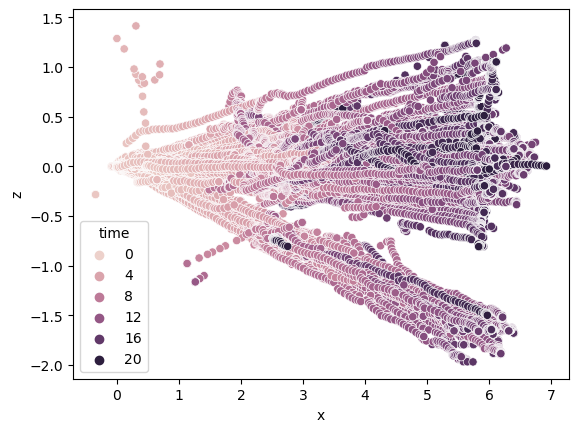

In [12]:
## First, plot all the trajectory points for Spot (dominant)

df_traj_Spot = get_trajectory_df(pp_ids = ["%02d" % x for x in range(1, 22)], apparance = 'dom', position_of = 'Spot', scenario = 'fronting');
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')

0      0.559954
1      0.559063
2      0.557542
3      0.556121
4      0.555395
         ...   
202   -0.031315
203   -0.031143
204   -0.031637
205   -0.032425
206   -0.031672
Name: z, Length: 207, dtype: float64
0     -0.012063
1     -0.010011
2     -0.008765
3     -0.013195
4     -0.019200
         ...   
104   -0.360857
105   -0.367352
106   -0.372217
107   -0.386676
108   -0.399674
Name: z, Length: 109, dtype: float64
0     0.006034
1     0.005076
2     0.001290
3    -0.002257
4    -0.006411
        ...   
70   -0.838069
71   -0.836488
72   -0.840607
73   -0.844590
74   -0.848866
Name: z, Length: 75, dtype: float64
0      0.568031
1      0.566671
2      0.565311
3      0.565109
4      0.565607
         ...   
99    -0.062280
100   -0.045705
101   -0.028400
102    0.002364
103    0.030511
Name: z, Length: 104, dtype: float64
0      0.428843
1      0.428662
2      0.428729
3      0.429628
4      0.430617
         ...   
135    0.020214
136    0.020276
137    0.019459
138    0.018721


0     -0.109320
1     -0.109981
2     -0.109601
3     -0.108504
4     -0.108059
         ...   
207    0.311613
208    0.308061
209    0.305196
210    0.300177
211    0.297304
Name: z, Length: 212, dtype: float64
0     -0.030750
1     -0.031761
2     -0.031535
3     -0.030587
4     -0.028718
         ...   
271    0.271651
272    0.271705
273    0.270148
274    0.268268
275    0.268282
Name: z, Length: 276, dtype: float64
0     -0.305145
1     -0.305145
2     -0.305145
3     -0.305145
4     -0.305145
         ...   
192   -0.029849
193   -0.026086
194   -0.021002
195   -0.025665
196   -0.023331
Name: z, Length: 197, dtype: float64
0      0.034732
1      0.035273
2      0.036095
3      0.037713
4      0.038171
         ...   
152    0.327691
153    0.327829
154    0.327690
155    0.327838
156    0.327264
Name: z, Length: 157, dtype: float64
0      0.004277
1      0.002095
2      0.000197
3     -0.002272
4     -0.004990
         ...   
156    0.262348
157    0.262907
158    0.263836
159 

<Axes: xlabel='x', ylabel='z'>

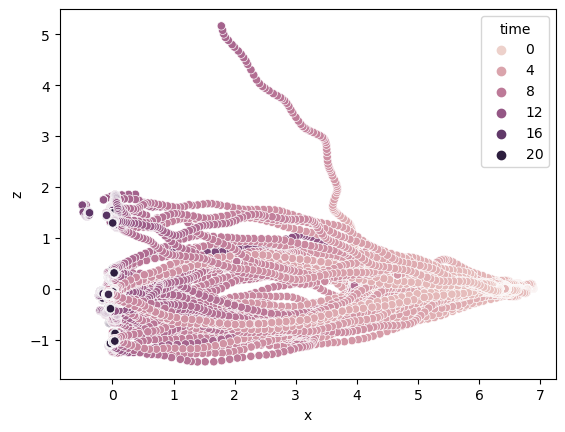

In [13]:
# Human, dominant
df_traj_Human = get_trajectory_df(pp_ids =  ["%02d" % x for x in range(1, 12)], apparance = 'dom', position_of = 'Human', scenario = 'fronting');
sns.scatterplot(data = df_traj_Human.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time' )

In [14]:
#sns.lineplot(data = df_traj_Human.loc[:, ['x', 'z','time']], x = 'x', y = 'z')
# Line plot is ugly here

In [ ]:
# Next idea
# Groupby participants -> draw 21 trajectories??
# (This part is not done.)

df_traj_Spot_pp = df_traj_Spot.groupby(['pp_id']).mean()
sns.scatterplot(data = df_traj_Spot.loc[: , ['x', 'z', 'time']], x = 'x', y = 'z', hue = 'time')